In [ ]:
!pip install tensorflow
!pip install scipy
!pip install matplotlib

In [ ]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from utils.cv_dp_utils.cnn_utils import *

%matplotlib inline
np.random.seed(1)

In [ ]:
# Carrega data set
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

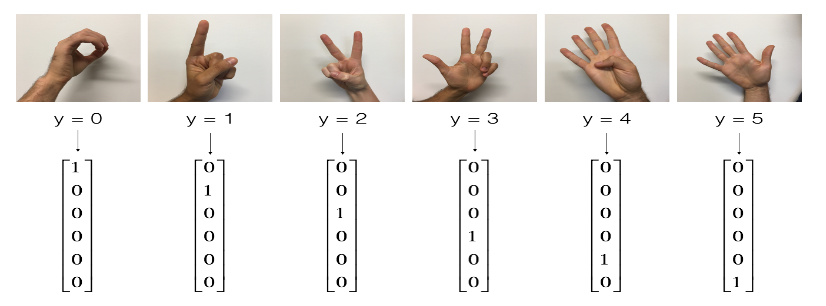

In [ ]:
# Exemplo de imagem
index = 6
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [ ]:
#Dados do dataset
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("Quantidade de exemplos de treino = " + str(X_train.shape[0]))
print ("Quantidade de exemplos de teste = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

In [ ]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    X = tf.placeholder(shape=[None, n_H0, n_W0, n_C0], dtype=tf.float32)
    Y = tf.placeholder(shape=[None, n_y], dtype=tf.float32)
    
    return X, Y

In [ ]:
def initialize_parameters():
    tf.set_random_seed(1)                    
        
    W1 = tf.get_variable("W1", [4, 4, 3, 8], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2", [2, 2, 8, 16], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
   
    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

In [ ]:
def forward_propagation(X, parameters):
    
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    
    # CONV2D: stride 1, padding 'SAME'
    s = 1
    Z1 = tf.nn.conv2d(X,W1, strides = [1,s,s,1], padding = 'SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
    f = s = 8
    P1 = tf.nn.max_pool(A1, ksize = [1,f,f,1], strides = [1,s,s,1], padding = 'SAME')
    # CONV2D: filters W2, stride 1, padding 'SAME'
    s = 1
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,s,s,1], padding = 'SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    f = s = 4
    P2 = tf.nn.max_pool(A2, ksize = [1,f,f,1], strides = [1,s,s,1], padding = 'SAME')
    # FLATTEN
    F2 = tf.contrib.layers.flatten(P2)
    # FULLY-CONNECTED 
    # 6 de saída 
    Z3 = tf.contrib.layers.fully_connected(F2, 6, activation_fn=None)


    return Z3

In [ ]:
def compute_cost(Z3, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
        
    return cost

In [ ]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True):
    
    
    ops.reset_default_graph()                         
    tf.set_random_seed(1)                            
    seed = 3                                        
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                       
    
    
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
   
    cost = compute_cost(Z3, Y)
   
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
     
    
    with tf.Session() as sess:
        
        sess.run(init)
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                
                (minibatch_X, minibatch_Y) = minibatch
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                minibatch_cost += temp_cost / num_minibatches
        
            if print_cost == True and epoch % 5 == 0:
                print ("Época: {} - Custo {}".format(epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        

        plt.plot(np.squeeze(costs))
        plt.ylabel('Custo')
        plt.xlabel('Iterações')
        plt.title("Taxa de aprendizado =" + str(learning_rate))
        plt.show()
        
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Acurácia de teino:", train_accuracy)
        print("Acurácia de teste:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

In [ ]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)